In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(u"datos_limpios/2014.csv")

In [2]:
sub_df = df[["GEN_ALU",
               'cat_periodo',
               'anio_ing_carr_ori',
               'anio_ing_carr_act',
               "rango_edad", 
               "tipo_inst_3", 
               "jornada", 
               "tipo_plan_carr", 
               "dur_estudio_carr", 
               "nivel_carrera_1", 
               "nivel_global", 
               "valor_matricula", 
               "valor_arancel", 
               "oecd_area", 
               "acreditada_carr", 
               "acreditada_inst"]]

sub_df = (sub_df.query("nivel_global=='Pregrado' or nivel_global.isnull()")
                 .drop(columns = ['nivel_global'])
                 .dropna(subset=['anio_ing_carr_act']))

sub_df['anio_en_carr_actual'] = sub_df['anio_ing_carr_act'] - sub_df['cat_periodo']

# se pide que cat_periodo == anio_ing_carr_act para no contar a una misma persona todos los años
sub_df['class'] = sub_df.apply(lambda row: row.cat_periodo != row.anio_ing_carr_ori and row.cat_periodo == row.anio_ing_carr_act, axis = 1)
sub_df = sub_df.drop(columns = ['anio_ing_carr_ori', 'cat_periodo', 'anio_ing_carr_act'])

sub_df['acreditada_carr'] = sub_df['acreditada_carr'].replace('NO ACREDITADA', False, regex=True)
sub_df['acreditada_carr'] = sub_df['acreditada_carr'].replace('ACREDITADA', True, regex=True)
sub_df['acreditada_inst'] = sub_df['acreditada_inst'].replace('NO ACREDITADA', False, regex=True)
sub_df['acreditada_inst'] = sub_df['acreditada_inst'].replace('ACREDITADA', True, regex=True)

In [3]:
# Se obtienen los tipos de cada columa en un dataframe
df_sub_datatypes = (pd.DataFrame(sub_df.dtypes)
                    .reset_index()
                    .rename(columns = {0:'tipo', 'index' : 'columna'})
                    )

# para cada columna...
cols_name = list(sub_df).remove('GEN_ALU')
df_sub_one_hot = pd.get_dummies(sub_df[['GEN_ALU']], prefix='GEN_ALU')
for i in range(1, len(df_sub_datatypes)):
    col_name = df_sub_datatypes.iloc[i][0]
    
    # Si es que es de tipo object...
    if str(df_sub_datatypes.iloc[i][1]) == 'object':
        # se le aplica la transformación One Hot
        df_one_hot = pd.get_dummies(sub_df[[col_name]], prefix=col_name)
    else:
        df_one_hot = sub_df[[col_name]]
    df_sub_one_hot = pd.merge(df_sub_one_hot, df_one_hot, left_index=True, right_index=True)

df_sub_one_hot

,GEN_ALU,rango_edad_15 a 19 años,rango_edad_20 a 24 años,rango_edad_25 a 29 años,rango_edad_30 a 34 años,rango_edad_35 a 39 años,rango_edad_40 y más años,tipo_inst_3_Centros de Formación Técnica,tipo_inst_3_Institutos Profesionales,tipo_inst_3_Universidades Estatales CRUCH,...,oecd_area_Educación,oecd_area_Humanidades y Artes,"oecd_area_Ingeniería, Industria y Construcción",oecd_area_Salud y Servicios Sociales,oecd_area_Servicios,oecd_area_Sin área definida,acreditada_carr,acreditada_inst,anio_en_carr_actual,class
1177,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,False,False,0.0,False
1215,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,False,False,0.0,False
1220,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,True,True,-1.0,False
1230,2,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,True,True,-1.0,False
1231,2,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,False,True,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215062,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,False,False,-1.0,False
1215082,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,False,False,-1.0,False
1215085,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,False,False,-1.0,False
1215093,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,False,False,-1.0,False


<AxesSubplot:>

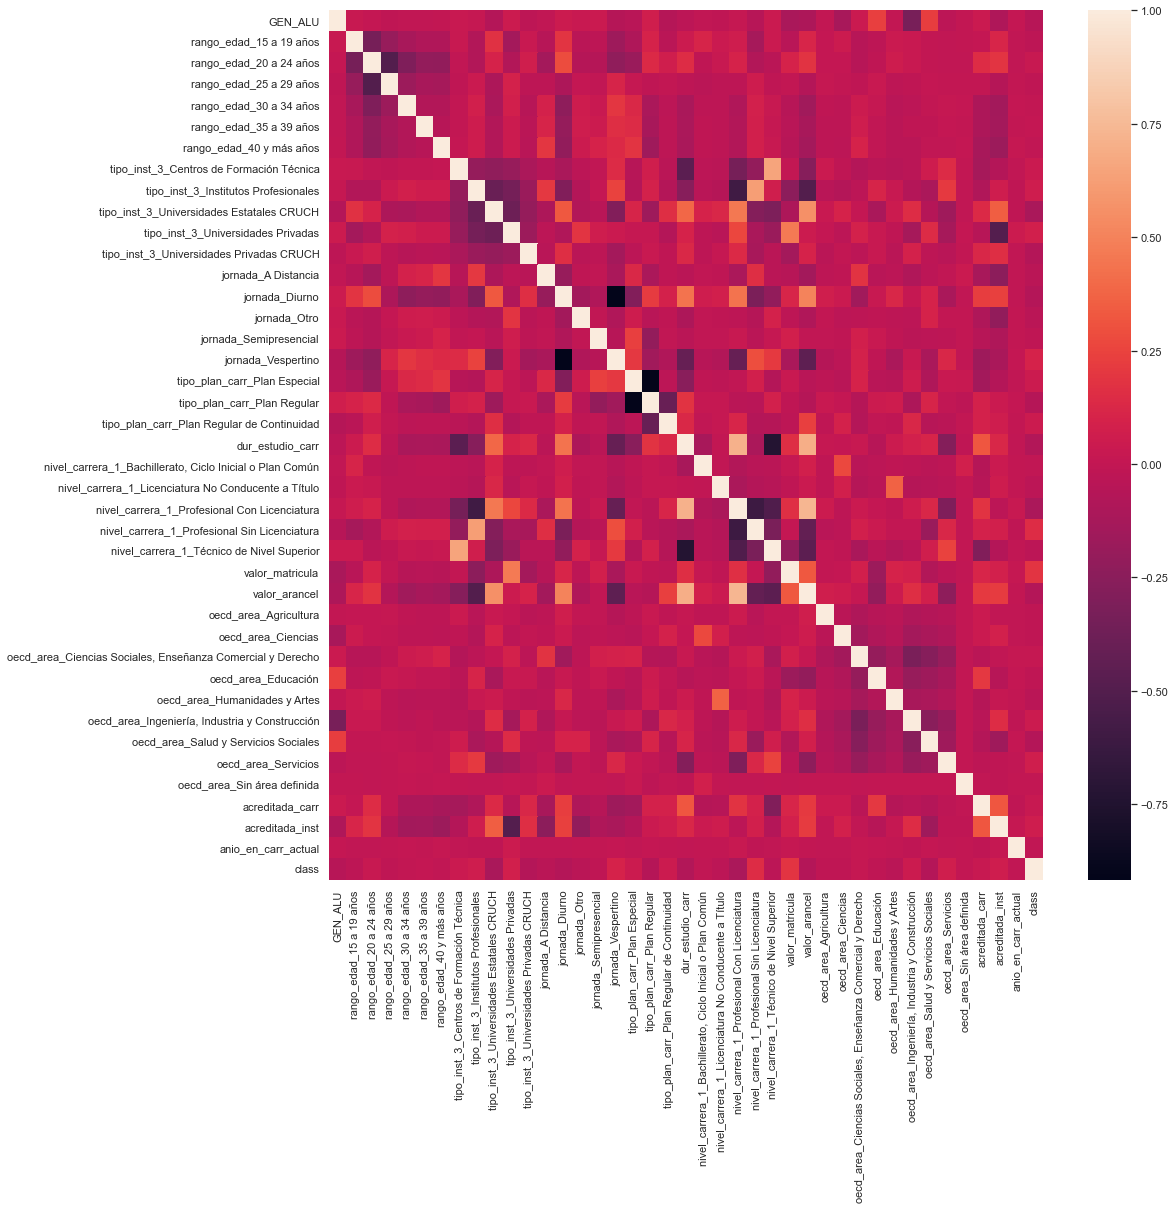

In [4]:
import seaborn

corr_sub = df_sub_one_hot.corr()
seaborn.set(rc={'figure.figsize':(16,16)})
seaborn.heatmap(corr_sub)

In [9]:
group = []
variable = []
value = []

for i in list(corr_sub):
    for j in list(corr_sub):
        group.append(i)
        variable.append(j)
        value.append(corr_sub[i][j])

df = pd.DataFrame({"group":group, "variable":variable, "value":value})
df.to_csv("onehot.csv", index=False)

1.0

In [6]:
from sklearn.decomposition import PCA

df = df_sub_one_hot.drop(columns = ['valor_matricula', 'valor_arancel'])
new_df = PCA(n_components=15, random_state=0).fit_transform(df)
new_df

array([[-2.99749189, -1.76134685,  0.42245649, ..., -0.07997948,
        -0.08906886, -0.0516487 ],
       [-2.99750241, -1.91341007, -0.2322664 , ...,  0.1146985 ,
        -0.1758349 , -0.02190924],
       [-3.99748364,  0.09802804,  0.05733281, ..., -0.67036552,
        -0.27264516, -0.27578325],
       ...,
       [-3.99714551,  4.08313424,  0.24855146, ...,  0.22084544,
        -0.05703294, -0.33334049],
       [-3.99711088,  4.09705654,  0.12274177, ...,  0.06964051,
         0.10943974, -0.24609366],
       [-3.99710393,  4.0938814 ,  0.0818473 , ...,  0.05671466,
        -0.04480846, -0.24577237]])